<a href="https://colab.research.google.com/github/MarciaFG/scimobility/blob/main/Shuffled_LaplacianMatrix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 800*800 Laplacian Matrix from Meso-Fields

* Calculate the Laplacian matrix of the square matrix.
* Calculate the eigenvalues and eigenvectors of the Laplacian matrix.
* Sort the eigenvalues in ascending order.
* The second smallest eigenvalue corresponds to the second eigenvector.
* Normalize the second eigenvector to have a unit length.

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, 
and then re-execute this cell.
Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [2]:
import numpy as np
import requests
import pandas as pd
from tqdm import tqdm
import torch
import nltk
import io
import matplotlib.pyplot as plt
from google.cloud import bigquery
from google.colab import files
import humanize
!pip install 'networkx<2.7'
!pip install 'scipy>=1.8'
#!pip install google-sheets-to-csv
# enable data table format
from google.colab import data_table
data_table.enable_dataframe_formatter()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 24.9 MB/s eta 0:00:00
  Attempting uninstall: networkx
    Found existing installation: networkx 3.0
    Uninstalling networkx-3.0:
      Successfully uninstalled networkx-3.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import os.path
from google.colab import drive

# mount Google Drive to /content/drive/My Drive/
if os.path.isdir("/content/drive/My Drive"):
  print("Google Drive already mounted")
else:
  drive.mount('/content/drive/')

Mounted at /content/drive/


In [35]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
id = '17RXABV5bp0-u_oSvKmKONW3f7FLzrjYl'
print (id) # Verify that you have everything
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('MesoFieldsMatrix.csv')  
edgelist = pd.read_csv('MesoFieldsMatrix.csv', sep=";") # Dataset is now stored in a Pandas Dataframe
print(edgelist.head(10))
print(edgelist.dtypes)

17RXABV5bp0-u_oSvKmKONW3f7FLzrjYl
   source  target  weight
0       0       1    5417
1       0       2       4
2       0       3      54
3       0       4      16
4       0       5       6
5       0       6      25
6       0       7       5
7       0       8     134
8       0       9     152
9       0      10   17347
source    int64
target    int64
weight    int64
dtype: object


In [39]:
import pandas as pd
import random

# shuffle the source column
shuffled_source = random.sample(list(edgelist['source']), len(edgelist))
edgelist_shuffled = edgelist.copy()
edgelist_shuffled['source'] = shuffled_source

# shuffle the target column using the shuffled source index
shuffled_target = random.sample(list(edgelist_shuffled['target']), len(edgelist_shuffled))
edgelist_shuffled_t = edgelist_shuffled.copy()
edgelist_shuffled_t['target'] = shuffled_target

print("Original edgelist:")
print(edgelist)
print("\nShuffled edgelist:")
print(edgelist_shuffled)
print("\nShuffled t edgelist:")
print(edgelist_shuffled_t)


Original edgelist:
        source  target  weight
0            0       1    5417
1            0       2       4
2            0       3      54
3            0       4      16
4            0       5       6
...        ...     ...     ...
545329     864     818       1
545330     864     819       4
545331     864     822       2
545332     864     824       1
545333     864     831       5

[545334 rows x 3 columns]

Shuffled edgelist:
        source  target  weight
0           46       1    5417
1          663       2       4
2          286       3      54
3          471       4      16
4          392       5       6
...        ...     ...     ...
545329     707     818       1
545330     260     819       4
545331     354     822       2
545332      21     824       1
545333     215     831       5

[545334 rows x 3 columns]

Shuffled t edgelist:
        source  target  weight
0           46     591    5417
1          663     310       4
2          286     350      54
3          471   

In [40]:
# concatenate the source and target columns to create a node list
nodelist = pd.concat([edgelist_shuffled_t['source'], edgelist_shuffled_t['target']]).unique()

# print the node list
print("Node list: ", nodelist[0:10])

Node list:  [ 46 663 286 471 392 457  24 313 447 159]


In [41]:
from networkx.linalg.graphmatrix import adjacency_matrix
import pandas as pd
import numpy as np
import networkx as nx

G=nx.from_pandas_edgelist(edgelist_shuffled_t,'source','target','weight')

In [42]:
Degrees = nx.degree(G, weight='weight')
print(Degrees[0])

153299


In [43]:
# Get the degree of each node in the graph
degrees = dict(G.degree(weight='weight'))

# Convert the degree dictionary to a NumPy array
degrees_array = np.array(list(degrees.values()))

# Print the degrees array
print(degrees_array)

[156019 130538 218459 175707 173653 129566 141872 133251 139060 159542
 205991 180383 192217 156070 117290 155866 139007 189492 147065 166849
 155541 136065 205754 154819 223234 189080 162233 190820 166857 127120
 180270 107680 164715 108554 307810 170051 160742 271113 133672  86784
 127492 154610 177949 134816 148346 174799 137211 157865 184017 194004
 149587 140414 223184 187965 120572 168951 111201 138231 128274 471131
 162077 189234 115881 164759 192109 191480 251797 113636 170652 145090
 181114 254395 258978 153528 118711 113323 156594 150319 111531 123727
 155902 168208 123066 211629 184381 126620 112116 189800 110107 139307
 191513 275320 222728 127878 154483 149312 187220 145605  94671 131310
 163248 128705 279508 120527  87993 154418 107414 171373 187766 197419
 112621 121269 203870 159524 188907 145009 161437  95158 247937 168780
  90934 146811 103654 168192 161226 141221 112637  98238 127698 106903
 178242 154515 146598 169134 149594 187557 146791  88656 251173 120900
 11334

In [44]:
# Compute the Laplacian matrix
# The graph Laplacian is the matrix L = D - A, where A is the adjacency matrix and D is the diagonal matrix of node degrees.
laplacian_matrix = nx.laplacian_matrix(G, nodelist = nodelist, weight='weight').astype(float)

# print the shape of the Laplacian matrix
print("Laplacian matrix shape: ", laplacian_matrix.shape)

# Convert the Laplacian matrix to a dense numpy array and inspect
laplacian_matrix_array = laplacian_matrix.toarray()
df = pd.DataFrame(laplacian_matrix_array, columns=G.nodes(), index=G.nodes())
print(df.head(5))

Laplacian matrix shape:  (865, 865)
          46        591       663       310       286     350  471    658  \
46   156019.0     -13.0      -8.0      -2.0       0.0    -3.0 -2.0   -2.0   
591     -13.0  218459.0      -7.0      -2.0      -1.0 -1317.0 -8.0    0.0   
663      -8.0      -7.0  173641.0    -199.0       0.0  -230.0 -2.0  -32.0   
310      -2.0      -2.0    -199.0  141872.0       0.0    -1.0  0.0  -13.0   
286       0.0      -1.0       0.0       0.0  139060.0  -888.0 -5.0 -481.0   

        392     117  ...     524   564    719     774   801    814    425  \
46    -22.0    -1.0  ...  -164.0 -11.0  -30.0    -3.0 -43.0 -113.0  -67.0   
591    -1.0   -52.0  ...     0.0  -1.0    0.0    -1.0  -6.0    0.0    0.0   
663   -63.0    -1.0  ... -1210.0  -1.0 -225.0 -2115.0  -2.0    0.0   -1.0   
310 -3429.0 -3102.0  ...    -4.0 -29.0    0.0     0.0   0.0    0.0    0.0   
286    -3.0 -3093.0  ...     0.0 -15.0  -11.0     0.0  -1.0    0.0 -674.0   

       828    845    811  
46    -3.0 

In [45]:
ones = np.ones(865)
#print(ones)

laplacian_matrix * ones

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [46]:
import scipy.sparse.linalg

# compute all the eigenvalues and eigenvectors of the Laplacian matrix
eigenvalues, eigenvectors = scipy.linalg.eigh(laplacian_matrix.toarray())

# print the Laplacian eigenvalues
print("Laplacian eigenvalues: ", eigenvalues)
print("Laplacian eigenvectors: ", eigenvectors)

Laplacian eigenvalues:  [-9.21756406e-11  3.96323346e+04  5.17097475e+04  5.67628782e+04
  6.23899435e+04  6.73161362e+04  7.14863557e+04  7.53691074e+04
  7.57601739e+04  7.70657870e+04  7.76306855e+04  7.88660811e+04
  7.92301257e+04  7.93913901e+04  8.03756492e+04  8.06811330e+04
  8.13163469e+04  8.17028810e+04  8.20185514e+04  8.23686647e+04
  8.24430975e+04  8.28477048e+04  8.30870129e+04  8.34547286e+04
  8.38178731e+04  8.39210857e+04  8.41705582e+04  8.44142704e+04
  8.48953437e+04  8.49785315e+04  8.52550717e+04  8.53022471e+04
  8.54944052e+04  8.57911008e+04  8.60083575e+04  8.60909399e+04
  8.65069322e+04  8.66023165e+04  8.71419921e+04  8.73356588e+04
  8.76534301e+04  8.77312601e+04  8.80347334e+04  8.80959033e+04
  8.83064233e+04  8.85056616e+04  8.85576676e+04  8.87005469e+04
  8.89709729e+04  8.91986445e+04  8.93587572e+04  8.95404506e+04
  8.96552331e+04  8.98826146e+04  9.01618782e+04  9.02863312e+04
  9.05053883e+04  9.06795242e+04  9.08449115e+04  9.09400754e+04
 

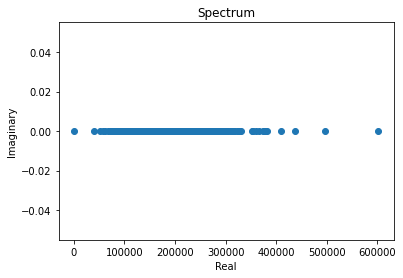

In [47]:
# Plot the eigenvalues
plt.scatter(np.real(eigenvalues), np.imag(eigenvalues))
plt.xlabel("Real")
plt.ylabel("Imaginary")
plt.title("Spectrum")
plt.show()

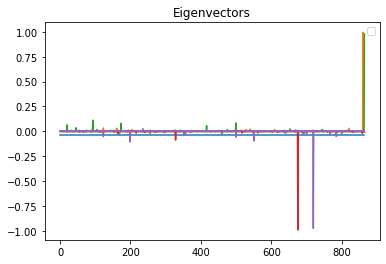

In [48]:
# Plot the first three eigenvectors
for i in range(5):
    plt.plot(eigenvectors[:, i])
plt.legend()
plt.title("Eigenvectors")
plt.show()

In [49]:
print("Number of eigenvectors:", eigenvectors.shape[1])

Number of eigenvectors: 865


Text(0, 0.5, 'third_eigenvector')

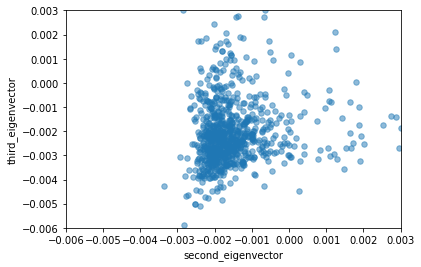

In [50]:
v1 = eigenvectors[:, 0]
v2 = eigenvectors[:, 1]
v3 = eigenvectors[:, 2]

# make a scatterplot of the second and the third eigenvectors
# Set custom axis ranges
plt.xlim(-0.006, 0.003)
plt.ylim(-0.006, 0.003)

plt.scatter(v2, v3, s=30, alpha = 0.5)
plt.xlabel('second_eigenvector')
plt.ylabel('third_eigenvector')

In [51]:
# Extract the second eigenvector and corresponding eigenvalue
second_eigenvalue = eigenvalues[1]
second_eigenvector = eigenvectors[:, 1]

# Sort the second eigenvector in ascending order
sort_index = np.argsort(second_eigenvector)
second_eigenvector = second_eigenvector[sort_index]

# Keep track of the original indices of the Laplacian Matrix
original_indices = np.arange(len(second_eigenvector))[sort_index]

print("Second Eigenvalue:", second_eigenvalue)
print("Sorted Second Eigenvector:", second_eigenvector)
print("Original Indices:", original_indices)

Second Eigenvalue: 39632.33463224073
Sorted Second Eigenvector: [-6.82818082e-03 -4.69634469e-03 -4.15801328e-03 -3.36843874e-03
 -2.98060310e-03 -2.92877860e-03 -2.86883779e-03 -2.85802271e-03
 -2.81268779e-03 -2.78785814e-03 -2.77927009e-03 -2.75190563e-03
 -2.73980941e-03 -2.70790199e-03 -2.68562596e-03 -2.67544912e-03
 -2.65854158e-03 -2.62386664e-03 -2.61340570e-03 -2.60315084e-03
 -2.58642873e-03 -2.56427256e-03 -2.55655107e-03 -2.55501821e-03
 -2.53903087e-03 -2.52138287e-03 -2.51883741e-03 -2.51580363e-03
 -2.50184910e-03 -2.49318035e-03 -2.48188692e-03 -2.46825682e-03
 -2.46779689e-03 -2.46188786e-03 -2.45670666e-03 -2.45645764e-03
 -2.44871856e-03 -2.43773570e-03 -2.43686197e-03 -2.43544112e-03
 -2.42861281e-03 -2.42783422e-03 -2.42775862e-03 -2.42615978e-03
 -2.42076174e-03 -2.41171827e-03 -2.41153938e-03 -2.40388233e-03
 -2.40129879e-03 -2.39624565e-03 -2.39226161e-03 -2.39201120e-03
 -2.39092211e-03 -2.38915492e-03 -2.38246343e-03 -2.38199604e-03
 -2.38194342e-03 -2.381497

In [52]:
# Create a pandas DataFrame with two columns
data = {'second_eigenvector': second_eigenvector, 'original_indices': original_indices}
df = pd.DataFrame(data)

df['cluster2'] = (df.index // 2).astype(int)
df['cluster3'] = (df.index // 3).astype(int)
df['cluster4'] = (df.index // 4).astype(int)
df['cluster5'] = (df.index // 5).astype(int)
df['cluster10'] = (df.index // 10).astype(int)
print(df)

     second_eigenvector  original_indices  cluster2  cluster3  cluster4  \
0             -0.006828               864         0         0         0   
1             -0.004696               675         0         0         0   
2             -0.004158               235         1         0         0   
3             -0.003368                75         1         1         0   
4             -0.002981               669         2         1         1   
..                  ...               ...       ...       ...       ...   
860            0.023043               540       430       286       215   
861            0.030119               821       430       287       215   
862            0.030561               161       431       287       215   
863            0.034149               123       431       287       215   
864            0.995886               860       432       288       216   

     cluster5  cluster10  
0           0          0  
1           0          0  
2           0     

In [53]:
df.to_csv('second_eigenvector_clustering_shuffled.csv')
!cp second_eigenvector_clustering.csv "drive/My Drive/"

cp: cannot stat 'second_eigenvector_clustering.csv': No such file or directory


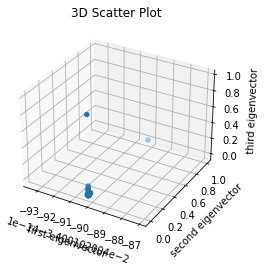

In [54]:
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(v1, v2, v3)

# Add labels and title
ax.set_xlabel('first eigenvector')
ax.set_ylabel('second eigenvector')
ax.set_zlabel('third eigenvector')
ax.set_title('3D Scatter Plot')

# Display the plot
plt.show()

In [55]:
laplacian_matrix * v2
el = 7.82882617e-01 /v2[0]
print(el)

-1083.347874666812


3. Sort eigenvalues and eigenvectors: Once you have the eigenvalues and eigenvectors of the Laplacian matrix, you can sort them in ascending order of eigenvalues to identify the most important eigenvectors. Here's an example:

In [56]:
# Sort the eigenvalues in ascending order
sort_index = np.argsort(eigenvalues)
eigenvalues = eigenvalues[sort_index]
eigenvectors = eigenvectors[:, sort_index]

print("Eigenvalues:", eigenvalues)
print("Eigenvectors:")
print(eigenvectors)

Eigenvalues: [-9.21756406e-11  3.96323346e+04  5.17097475e+04  5.67628782e+04
  6.23899435e+04  6.73161362e+04  7.14863557e+04  7.53691074e+04
  7.57601739e+04  7.70657870e+04  7.76306855e+04  7.88660811e+04
  7.92301257e+04  7.93913901e+04  8.03756492e+04  8.06811330e+04
  8.13163469e+04  8.17028810e+04  8.20185514e+04  8.23686647e+04
  8.24430975e+04  8.28477048e+04  8.30870129e+04  8.34547286e+04
  8.38178731e+04  8.39210857e+04  8.41705582e+04  8.44142704e+04
  8.48953437e+04  8.49785315e+04  8.52550717e+04  8.53022471e+04
  8.54944052e+04  8.57911008e+04  8.60083575e+04  8.60909399e+04
  8.65069322e+04  8.66023165e+04  8.71419921e+04  8.73356588e+04
  8.76534301e+04  8.77312601e+04  8.80347334e+04  8.80959033e+04
  8.83064233e+04  8.85056616e+04  8.85576676e+04  8.87005469e+04
  8.89709729e+04  8.91986445e+04  8.93587572e+04  8.95404506e+04
  8.96552331e+04  8.98826146e+04  9.01618782e+04  9.02863312e+04
  9.05053883e+04  9.06795242e+04  9.08449115e+04  9.09400754e+04
  9.13066121

In [ ]:
idx = eigenvalues.argsort()
eigenValues = eigenvalues[idx]
eigenVectors = eigenvectors[:,idx]

# print the sorted eigenvalues and eigenvectors
print("Sorted eigenvalues: ", eigenValues)
print("Sorted eigenvectors: ", eigenVectors)

In [58]:
# Determine the minimum and maximum values of the data
min_val = np.min(eigenVectors)
max_val = np.max(eigenVectors)

print(min_val)
print(max_val)

min_vall = np.min(eigenValues)
max_vall= np.max(eigenValues)

print(min_vall)
print(max_vall)

-0.9915005197672634
0.9958860194614809
-9.217564059850902e-11
601790.7038080969


## Adjacency Matrix Plot

In [59]:
from scipy.sparse import csr_matrix
import numpy as np

# Convert the graph to a NumPy array
adjacency = nx.to_numpy_array(G)
# Calculate the mean and standard deviation of the csr_matrix
mean = adjacency.mean()
std = np.std(adjacency)

# Print the results
print(f"Mean: {mean}")
print(f"Standard deviation: {std}")

Mean: 184.59313709111564
Standard deviation: 1491.0063743017463


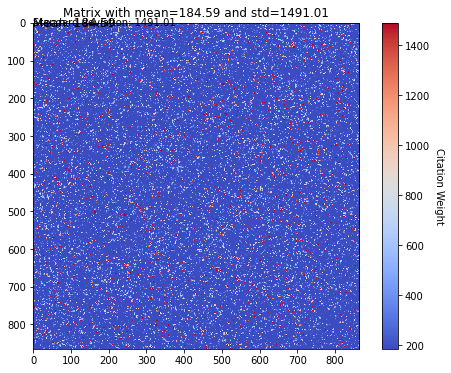

In [60]:
# Plot the matrix as a heatmap with the mean and standard deviation
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(adjacency, cmap='coolwarm', vmin= mean, vmax=std)
ax.set_title(f"Matrix with mean={mean:.2f} and std={std:.2f}")
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Citation Weight", rotation=-90, va="bottom")

# Add the mean and standard deviation to the plot
ax.text(0, -1, f"Mean: {mean:.2f}", fontsize=12, ha="left", va="center")
ax.text(0, -2, f"Standard deviation: {std:.2f}", fontsize=10, ha="left", va="center")

plt.show()

# Simple Laplacian Plot (not normalized)

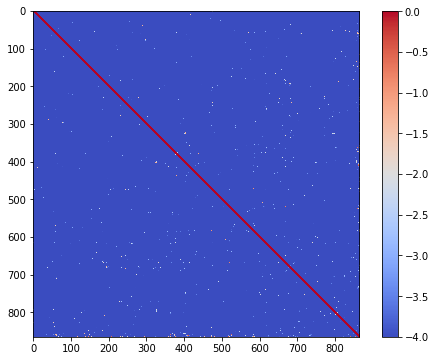

In [61]:
fig, ax = plt.subplots(figsize=(8, 6))
mean = laplacian_matrix_array.mean()
std = np.std(laplacian_matrix_array)

im = ax.imshow(laplacian_matrix_array, cmap='coolwarm', vmin=-4, vmax=0.01)
cbar = ax.figure.colorbar(im, ax=ax)

## Degree Matrix Plot (Weighted degrees)

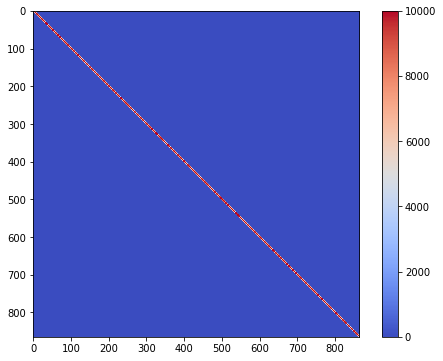

In [62]:
# Create a 2D array of zeros with the same shape as the adjacency matrix
degree_matrix = np.zeros((len(degrees), len(degrees)))

# Set the diagonal elements of the degree matrix to the corresponding degree values
np.fill_diagonal(degree_matrix, degrees_array)

# Plot the degree matrix as a heatmap
from matplotlib.colors import Normalize

# Normalize the data to the range of 0 to 1
norm = Normalize(vmin=0, vmax=10000)

fig, ax = plt.subplots(figsize=(8, 6))
plt.imshow(degree_matrix, cmap='coolwarm', norm=norm)
plt.colorbar()
plt.show()

# Spectral Clustering

In [ ]:
# choosing parameter k
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import numpy as np
# assume X is the data matrix
# assume L is the Laplacian matrix
# assume eigvecs are the eigenvectors of L
# assume eigvals are the eigenvalues of L

# define a range of k values to try
k_values = range(2, 10)

# compute the silhouette score for each value of k
silhouette_scores = []
for k in k_values:
    embedding = eigenvectors[:, :k]
    kmeans = KMeans(n_clusters=k)
    labels = kmeans.fit_predict(embedding)
    sil_score = silhouette_score(embedding, labels)
    silhouette_scores.append(sil_score)

# find the value of k that maximizes the silhouette score
best_k = k_values[np.argmax(silhouette_scores)]

In [ ]:
best_k

2

In [ ]:
from sklearn.cluster import SpectralClustering
# choose the number of dimensions for the embedding
k = 2

# take the k smallest eigenvectors and use them to embed the data
embedding = eigenvectors[:, :k]

# perform spectral clustering with the optimal number of clusters
spectral = SpectralClustering(n_clusters=best_k, affinity='nearest_neighbors', assign_labels='kmeans')
labels = spectral.fit_predict(embedding)

# print the cluster labels
print(labels)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0
 0 0 0 0 0 1 1 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 1
 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 1 0 0
 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1
 0 0 1 0 0 1 0 0 0 1 0 1 0 1 1 0 0 1 1 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1
 0 0 0 1 0 1 0 0 1 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0
 1 0 0 0 0 1 1 0 0 0 1 0 0 1 0 1 1 1 0 0 0 1 0 0 0 1 0 1 0 1 0 1 0 1 0 0 0
 1 0 1 0 1 0 0 1 0 0 0 1 0 1 0 1 0 1 0 1 1 0 0 0 1 0 1 0 0 0 0 1 0 0 0 1 1
 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 1 0
 1 0 1 0 0 0 1 0 0 1 1 0 1 1 0 1 0 0 1 0 1 1 0 0 0 0 1 0 0 0 1 0 1 1 0 0 1
 0 1 0 1 0 0 1 0 0 0 0 0 0 1 1 0 0 0 1 0 1 1 1 0 0 1 1 0 0 1 0 0 0 0 1 0 0
 0 0 1 1 1 1 1 0 1 1 0 0 0 1 0 0 0 0 0 1 0 1 1 0 0 1 1 1 0 1 1 1 0 0 0 1 1
 0 1 1 0 0 1 1 0 0 0 0 1 

In [ ]:
"""
# count the number of nonzero eigenvalues
num_nonzero_eigenvalues = np.count_nonzero(sorted_eigenvalues)

# count the number of zero eigenvalues
num_zero_eigenvalues = len(sorted_eigenvalues) - num_nonzero_eigenvalues

# print the number of zero eigenvalues
print("Number of zero eigenvalues: ", num_zero_eigenvalues)
print("Number of nonzero eigenvalues: ", num_nonzero_eigenvalues)
"""

Number of zero eigenvalues:  0
Number of nonzero eigenvalues:  3


In [ ]:
"""
num_nonzero_eigenvalues = np.count_nonzero(sorted_eigenvalues)

# count the number of zero eigenvalues
num_zero_eigenvalues = len(sorted_eigenvalues) - num_nonzero_eigenvalues

# print the number of zero eigenvalues
print("Number of zero eigenvalues: ", num_zero_eigenvalues)
"""

Number of zero eigenvalues:  0
